# `photoeccentric` sensitivitiy tests

This notebook sets up a sensitivity test for `photoeccentric` to determine how accurately it recovers eccentricity with simulated transits. In general, this is also how I would structure the code to recover eccentricities for a large number of planets in sequence.

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from astropy.table import Table
import astropy.units as u

# Using `batman` to create & fit fake transit
import batman

# Using astropy BLS and scipy curve_fit to fit transit
from astropy.timeseries import BoxLeastSquares
from scipy.optimize import curve_fit

import scipy.optimize as opt

# Using emcee & corner to find and plot (e, w) distribution
import emcee
import corner

# And importing `photoeccentric`
import photoeccentric as ph

# Random stuff
import scipy.constants as c
import os

%load_ext autoreload
%autoreload 2

%matplotlib inline

plt.rcParams['figure.figsize'] = [12, 8]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


I'll fit the transits with `emcee`, which takes a number of walkers, steps, and steps to discard. I'm defining them here so I can create my planet parameter distributions (period, rp/rs, a/rs, inclination) to be the proper length.

In [34]:
nwalk = 64
nsteps_d = 3000
ndiscard_d = 1000
arrlen = (nsteps_d-ndiscard_d)*nwalk

In [35]:
smass_kg = 1.9885e30  # Solar mass (kg)
srad_m = 696.34e6 # Solar radius (m)

## Reading in Sample Data

To run with Kepler light curves, 

In [36]:
muirhead_data = pd.read_csv("datafiles/Muirhead2013_isochrones/muirhead_data_no_missing_data.txt", sep=" ")

# ALL Kepler planets from exo archive
planets = pd.read_csv('datafiles/exoplanetarchive/cumulative_kois.csv')

# Take the Kepler planet archive entries for the planets in Muirhead et al. 2013 sample
spectplanets = planets[planets['kepid'].isin(list(muirhead_data['KIC']))]
spectplanets = spectplanets.reset_index()

# Kepler-Gaia Data
kpgaia = Table.read('datafiles/Kepler-Gaia/kepler_dr2_4arcsec.fits', format='fits').to_pandas();

# Kepler-Gaia data for only the objects in our sample
muirhead_gaia = kpgaia[kpgaia['kepid'].isin(list(muirhead_data.KIC))]
muirhead_gaia = muirhead_gaia.reset_index()
muirhead_gaia.rename(columns={"index": "KIC"})

# Combined spectroscopy data + Gaia/Kepler data for our sample
muirhead_comb = pd.concat([muirhead_data, muirhead_gaia], axis=1)
muirhead_comb_nn = muirhead_comb[muirhead_comb.KOI.notnull()]

# Only targets from table above with published luminosities from Gaia
muirhead_comb_lums = muirhead_comb_nn[muirhead_comb_nn.lum_val.notnull()]

# Read in MESA isochrones
isochrones = pd.read_csv('datafiles/Muirhead2013_isochrones/isochrones_sdss_spitzer_lowmass.dat', sep='\s\s+', engine='python')

/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'r_result_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'r_modality_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'teff_err1' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'teff_err2' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


## Outline for Sensitivity Test

1. Define "test planet" parameters. These parameters will come from a real Kepler planet, but I'll use a fake light curve. These "test planet" parameters will stay the same across the entire test.
2. Write two functions: one that wraps the entire light curve initialization process, and one that wraps the transit fit and eccentricity estimation.
3. For each eccentricity recovered, take the difference between the input e and the peak of the e distribution as the error.
4. Plot on a heatmap

#### Defining a "test planet"

In [37]:
# Kepler ID for Kepler-1582 b
kepid = 5868793
kepname = spectplanets.loc[spectplanets['kepid'] == kepid].kepler_name.values[0]

kp1582b = muirhead_comb.loc[muirhead_comb['KIC'] == kepid]

iso_lums = ph.fit_isochrone_lum(kp1582b, muirhead_comb, isochrones, gaia_lum=True)

# Write to csv, then read back in (keeps python notebook from crashing)
iso_lums.to_csv("datafiles/isochrones/iso_lums_" + str(kepid) + ".csv")

100%|██████████| 738479/738479 [01:01<00:00, 11977.96it/s]


In [40]:
isodf = pd.read_csv("datafiles/isochrones/iso_lums_" + str(kepid) + ".csv")

mstar = isodf["mstar"].mean()
mstar_err = isodf["mstar"].std()

rstar = isodf["radius"].mean()
rstar_err = isodf["radius"].std()

rho_star, mass, radius = ph.find_density_dist_symmetric(mstar, mstar_err, rstar, rstar_err, arrlen)

Text(0.5, 0, 'Stellar Density (KIC 5868793) [kg m^-3]')

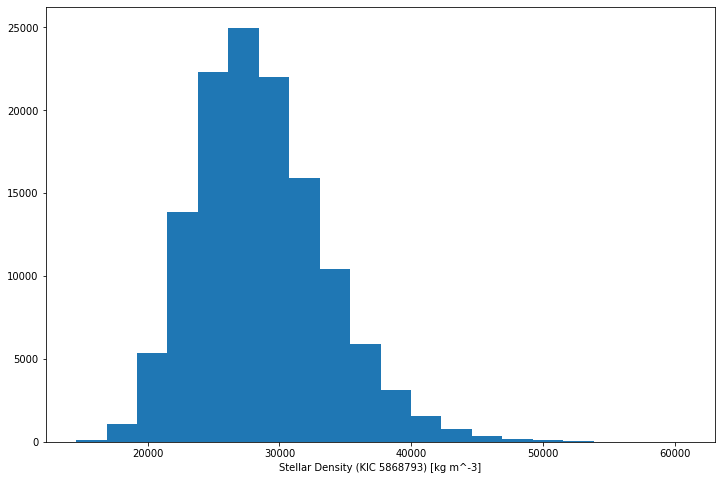

In [50]:
plt.hist(rho_star, bins=20)
plt.xlabel("Stellar Density (KIC 5868793) [kg m^-3]")

In [51]:
period, period_uerr, period_lerr, rprs, rprs_uerr, rprs_lerr, a_arc, a_uerr_arc, a_lerr_arc, i, e_arc, w_arc = ph.planet_params_from_archive(spectplanets, kepname)

# We calculate a_rs to ensure that it's consistent with the spec/Gaia stellar density.
a_rs = ph.calc_a(period*86400.0, mstar*smass_kg, rstar*srad_m)
a_rs_err = np.mean((a_uerr_arc, a_lerr_arc))

print('Stellar mass (Msun): ', mstar, 'Stellar radius (Rsun): ', rstar)
print('Period (Days): ', period, 'Rp/Rs: ', rprs)
print('a/Rs: ', a_rs)
print('i (deg): ', i)

Stellar mass (Msun):  0.18620280162489727 Stellar radius (Rsun):  0.21038847941706276
Period (Days):  4.83809469 Rp/Rs:  0.036066
a/Rs:  32.64384979582086
i (deg):  89.98


##### Calculate A_rs prior:

In [52]:
pdist = np.random.normal(period, np.mean((abs(period_uerr), abs(period_lerr))), len(rhos_gaia))
a_rs_gaia = ph.get_a_rs(rhos_gaia, pdist)
a_rs_gaia_sigmin, a_rs_gaia_sigpls = ph.get_sigmas(a_rs_gaia)
a_rs_guess = np.mean(a_rs_gaia)
a_rs_priors = [a_rs_guess-10*np.std(a_rs_gaia), a_rs_guess+10*np.std(a_rs_gaia)]

# Using photo_init and photo_fit

In [24]:
e_rand = np.random.uniform(0.0, 1.0, size=50)
w_rand = np.random.uniform(-90.0, 90.0, size=50)

In [25]:
# Testing how accurately MCMC fits period/radius/i/ars...

In [26]:
gmeans = np.zeros(50)
gsigs = np.zeros(50)
es_best = np.zeros(50)
ws_best = np.zeros(50)
zscores = np.zeros((50, 2))

In [27]:
print('Period (Days): ', period)
print('Rp/Rs: ', rprs)
print('a/Rs: ', a_rs)
print('i (deg): ', i)

for j in range(50):
    print('e: ', e_rand[j], 'w: ', w_rand[j])
    
    dr = 'e_' + str(e_rand[j]) + '_w_' + str(w_rand[j])
    direct = '/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/plots/' + dr + '/'
    
    if not os.path.exists(direct):
        os.mkdir(direct)
    
    ttime = np.linspace(-24, 24, 10000)
    tflux, tflux_err = ph.photo_init(ttime, period, rprs, a_rs, e_rand[j], i, w_rand[j])

    # nsteps kept 1000, nwalkers 32, len(result) 32000
    
    guess_transit = np.array([ph.bls(ttime, tflux), 0.036066, a_rs_guess, 89.9, 90.0])
    guess_ew = np.array([0, 0])
    
    beste, bestw, edist, wdist, gs, g_mean, g_sigmas, zsc = ph.photo_fit(ttime, tflux, tflux_err, guess_transit, guess_ew, rho_star, e_rand[j], w_rand[j], direct, nwalk, nsteps_d, ndiscard_d) 
    gmeans[j] = g_mean
    gsigs[j] = np.mean(g_sigmas)
    es_best[j] = beste
    ws_best[j] = bestw
    zscores[j] = np.mean(zsc)
    print("Best e: ", beste)


Period (Days):  4.83809469
Rp/Rs:  0.036066
a/Rs:  32.64384979582086
i (deg):  89.98
e:  0.6976546770345987 w:  -32.76156666977628


100%|██████████| 3000/3000 [06:33<00:00,  7.62it/s]


Fit params:
Period (days):  4.838110464598366 Rp/Rs:  0.036090583047493865
a/Rs:  28.006819366340192
i (deg):  89.72172802130181


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  3%|▎         | 146/5000 [00:00<00:06, 731.36it/s]

0.8580690965500599
-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 792.34it/s]


Best e:  0.263245006249461
e:  0.7334576701260733 w:  26.41695279099784


100%|██████████| 3000/3000 [05:36<00:00,  8.92it/s]


Fit params:
Period (days):  4.838105431139109 Rp/Rs:  0.0363202902843323
a/Rs:  58.78733847941303
i (deg):  89.66751204302544


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  3%|▎         | 149/5000 [00:00<00:06, 735.74it/s]

1.8016853486363194
-------MCMC------


100%|██████████| 5000/5000 [00:07<00:00, 708.47it/s]


Best e:  0.6084705323245483
e:  0.19745843861804602 w:  65.71465572610091


100%|██████████| 3000/3000 [05:35<00:00,  8.94it/s]


Fit params:
Period (days):  4.838094702422973 Rp/Rs:  0.03611926331045529
a/Rs:  38.65460190459638
i (deg):  89.77205656863181


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|▏         | 69/5000 [00:00<00:07, 682.61it/s]

1.1845375670685705
-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 796.30it/s]


Best e:  0.2767952350026785
e:  0.27584635725487894 w:  -51.42462727238993


100%|██████████| 3000/3000 [05:35<00:00,  8.94it/s]


Fit params:
Period (days):  4.838092924204205 Rp/Rs:  0.03610602572515358
a/Rs:  26.266630666080026
i (deg):  89.68772274143336


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  3%|▎         | 158/5000 [00:00<00:06, 778.40it/s]

0.8047048102786014
-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 794.95it/s]


Best e:  0.33350680057705806
e:  0.7991026779855654 w:  -78.0379422460789


100%|██████████| 3000/3000 [05:36<00:00,  8.91it/s]


Fit params:
Period (days):  4.838094344760863 Rp/Rs:  0.03609761093374571
a/Rs:  11.748356680124067
i (deg):  89.4272883208351


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|▏         | 73/5000 [00:00<00:06, 727.21it/s]

0.35921926413861244
-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 759.41it/s]


Best e:  0.8150343833793999
e:  0.7458868859471193 w:  -43.96435729701904


100%|██████████| 3000/3000 [05:35<00:00,  8.94it/s]


Fit params:
Period (days):  4.8380962723667755 Rp/Rs:  0.03610405797122882
a/Rs:  23.24069917098638
i (deg):  89.62045198630165


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  3%|▎         | 164/5000 [00:00<00:05, 818.66it/s]

0.7119023598211679
-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 788.15it/s]


Best e:  0.4409989312999646
e:  0.6844794268912501 w:  42.88125084365859


100%|██████████| 3000/3000 [05:30<00:00,  9.08it/s]


Fit params:
Period (days):  4.841517944084131 Rp/Rs:  0.035755822496265355
a/Rs:  62.94889725242691
i (deg):  89.79856562908577


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 83/5000 [00:00<00:05, 820.66it/s]

1.9288544643594816
-------MCMC------


100%|██████████| 5000/5000 [00:07<00:00, 676.43it/s]


Best e:  0.6530234198926539
e:  0.19354366791181798 w:  58.39138319137132


100%|██████████| 3000/3000 [05:34<00:00,  8.98it/s]


Fit params:
Period (days):  4.839212481149301 Rp/Rs:  0.0357269865688094
a/Rs:  37.970561908340045
i (deg):  89.7631037087225


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  3%|▎         | 150/5000 [00:00<00:06, 705.43it/s]

1.1634166093559737
-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 793.03it/s]


Best e:  0.25996254689939047
e:  0.997924770703234 w:  -71.58734138318005


100%|██████████| 3000/3000 [05:37<00:00,  8.89it/s]


Fit params:
Period (days):  4.838278201817271 Rp/Rs:  0.15722065348276795
a/Rs:  9.889423153873182
i (deg):  81.64324105064141


/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/photoeccentric/photoeccentric.py:135: RuntimeWarning: invalid value encountered in sqrt
  T23[j] = (p[j]/np.pi)*np.arcsin(rs_a[j]*(np.sqrt(((1-rprs[j])**2)-b[j]**2))/np.sin(i[j]*(np.pi/180.0))) #Equation 14 in exoplanet textbook
  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 82/5000 [00:00<00:06, 818.44it/s]

0.6012235613526642
-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 786.25it/s]


Best e:  0.5751590329565079
e:  0.2640928642153224 w:  -11.417685100414161


100%|██████████| 3000/3000 [05:32<00:00,  9.02it/s]


Fit params:
Period (days):  4.838093399974759 Rp/Rs:  0.0361167193290352
a/Rs:  31.66818424733577
i (deg):  89.7589140405888


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 76/5000 [00:00<00:06, 753.14it/s]

0.9703388381411324
-------MCMC------


100%|██████████| 5000/5000 [00:05<00:00, 866.23it/s]


Best e:  0.11742901023463514
e:  0.38074027148907064 w:  -9.158701070632091


100%|██████████| 3000/3000 [05:36<00:00,  8.92it/s]


Fit params:
Period (days):  4.83809358879205 Rp/Rs:  0.036123318883027083
a/Rs:  32.54691447259643
i (deg):  89.71031745887278


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  3%|▎         | 160/5000 [00:00<00:06, 788.27it/s]

0.9972789057849444
-------MCMC------


100%|██████████| 5000/5000 [00:05<00:00, 844.32it/s]


Best e:  0.12755077530923964
e:  0.7321354353602801 w:  70.18517959866645


100%|██████████| 3000/3000 [05:43<00:00,  8.73it/s]


Fit params:
Period (days):  4.838096456440514 Rp/Rs:  0.03638145729258585
a/Rs:  73.9065669403105
i (deg):  89.7056470719128


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 75/5000 [00:00<00:06, 745.91it/s]

2.2651746788688736
-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 759.26it/s]


Best e:  0.7319161683178402
e:  0.025704791834708862 w:  -10.0408193450953


100%|██████████| 3000/3000 [05:30<00:00,  9.09it/s]


Fit params:
Period (days):  4.838092632340664 Rp/Rs:  0.03612081197341396
a/Rs:  31.98203289461192
i (deg):  89.72984539453772


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 75/5000 [00:00<00:06, 748.59it/s]

0.9799574808445931
-------MCMC------


100%|██████████| 5000/5000 [00:05<00:00, 860.76it/s]


Best e:  0.1214048045984277
e:  0.7974676015956067 w:  63.3942190364871


100%|██████████| 3000/3000 [05:31<00:00,  9.06it/s]


Fit params:
Period (days):  4.838140550324751 Rp/Rs:  0.0361883542525057
a/Rs:  89.32678535092153
i (deg):  89.85331100199272


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  3%|▎         | 160/5000 [00:00<00:06, 795.94it/s]

2.7378394508684987
-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 777.80it/s]


Best e:  0.8056443813543126
e:  0.19225362779891642 w:  34.09311668489909


100%|██████████| 3000/3000 [05:33<00:00,  9.01it/s]


Fit params:
Period (days):  4.838104886380749 Rp/Rs:  0.03612422772993373
a/Rs:  36.0495745975719
i (deg):  89.71903649034482


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  3%|▎         | 159/5000 [00:00<00:06, 777.73it/s]

1.1046721553219994
-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 815.77it/s]


Best e:  0.1923017592812259
e:  0.9246480220028672 w:  71.33821687115335


100%|██████████| 3000/3000 [05:41<00:00,  8.79it/s]


Fit params:
Period (days):  4.792055137882534 Rp/Rs:  0.03714528521214581
a/Rs:  88.74746303851637
i (deg):  89.40219568343959


/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/photoeccentric/photoeccentric.py:135: RuntimeWarning: invalid value encountered in sqrt
  T23[j] = (p[j]/np.pi)*np.arcsin(rs_a[j]*(np.sqrt(((1-rprs[j])**2)-b[j]**2))/np.sin(i[j]*(np.pi/180.0))) #Equation 14 in exoplanet textbook
  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  3%|▎         | 131/5000 [00:00<00:07, 646.13it/s]

2.8382965875915174
-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 768.53it/s]


Best e:  0.7943491813046385
e:  0.850843278236018 w:  46.97923346193048


100%|██████████| 3000/3000 [05:12<00:00,  9.60it/s]


Fit params:
Period (days):  4.8498301970646915 Rp/Rs:  0.033696903972492434
a/Rs:  87.1782999598625
i (deg):  89.60626599675842


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  3%|▎         | 162/5000 [00:00<00:05, 814.18it/s]

2.670187640398443
-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 763.42it/s]


Best e:  0.7934232372095347
e:  0.8603047543357756 w:  9.13170250952902


100%|██████████| 3000/3000 [05:39<00:00,  8.84it/s]


Fit params:
Period (days):  4.8380973766499125 Rp/Rs:  0.03638437379278194
a/Rs:  65.56135765711139
i (deg):  89.6515358158854


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 86/5000 [00:00<00:05, 855.13it/s]

2.0093286993249446
-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 747.24it/s]


Best e:  0.6704857967645207
e:  0.6413300306774969 w:  10.07004055443005


100%|██████████| 3000/3000 [05:32<00:00,  9.02it/s]


Fit params:
Period (days):  4.838092839973205 Rp/Rs:  0.036126092204559146
a/Rs:  46.15476855786799
i (deg):  89.77096233550655


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 85/5000 [00:00<00:05, 845.00it/s]

1.414467566919184
-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 773.46it/s]


Best e:  0.4450238821370001
e:  0.8457352578150631 w:  65.67408705445868


100%|██████████| 3000/3000 [05:31<00:00,  9.05it/s]


Fit params:
Period (days):  5.032839388517837 Rp/Rs:  0.034145740701446776
a/Rs:  88.8689312189101
i (deg):  89.62734610541193


/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/photoeccentric/photoeccentric.py:135: RuntimeWarning: invalid value encountered in sqrt
  T23[j] = (p[j]/np.pi)*np.arcsin(rs_a[j]*(np.sqrt(((1-rprs[j])**2)-b[j]**2))/np.sin(i[j]*(np.pi/180.0))) #Equation 14 in exoplanet textbook
  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|▏         | 70/5000 [00:00<00:07, 695.80it/s]

2.708188664747881
-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 764.26it/s]


Best e:  0.7860940354082889
e:  0.061290248304871286 w:  72.47133128121814


100%|██████████| 3000/3000 [05:38<00:00,  8.85it/s]


Fit params:
Period (days):  4.8380970398510925 Rp/Rs:  0.036133234913202514
a/Rs:  33.83639982816958
i (deg):  89.6932220684511


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  3%|▎         | 131/5000 [00:00<00:07, 647.26it/s]

1.036809323702961
-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 764.95it/s]


Best e:  0.12143349077429347
e:  0.22956406061110612 w:  -72.8460094780284


100%|██████████| 3000/3000 [05:31<00:00,  9.05it/s]


Fit params:
Period (days):  4.838092559251397 Rp/Rs:  0.036132091084355916
a/Rs:  25.726463654872322
i (deg):  89.64289105262607


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 77/5000 [00:00<00:06, 766.06it/s]

0.7881438675025858
-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 792.88it/s]


Best e:  0.35753416614791445
e:  0.3868083665994886 w:  -2.0175793444336136


100%|██████████| 3000/3000 [05:30<00:00,  9.07it/s]


Fit params:
Period (days):  4.838082544661032 Rp/Rs:  0.03614772350277483
a/Rs:  34.067702405995696
i (deg):  89.68520363442967


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  3%|▎         | 163/5000 [00:00<00:06, 796.12it/s]

1.0439119272270905
-------MCMC------


100%|██████████| 5000/5000 [00:05<00:00, 849.55it/s]


Best e:  0.13298187012595317
e:  0.5329864971283009 w:  29.1314372222063


100%|██████████| 3000/3000 [05:32<00:00,  9.02it/s]


Fit params:
Period (days):  4.8389693426548 Rp/Rs:  0.035726911517278546
a/Rs:  47.011382394886205
i (deg):  89.76131280896851


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 85/5000 [00:00<00:05, 845.10it/s]

1.4406104106478992
-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 772.05it/s]


Best e:  0.44673757399656966
e:  0.17749921221264642 w:  -7.539282594211414


100%|██████████| 3000/3000 [05:31<00:00,  9.06it/s]


Fit params:
Period (days):  4.8380949925943115 Rp/Rs:  0.0361075383114404
a/Rs:  31.856581548234157
i (deg):  89.72198616896634


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  3%|▎         | 161/5000 [00:00<00:06, 792.34it/s]

0.9761165879311208
-------MCMC------


100%|██████████| 5000/5000 [00:05<00:00, 874.19it/s]


Best e:  0.11427449269729723
e:  0.38151917649275036 w:  -44.83913800977813


100%|██████████| 3000/3000 [05:30<00:00,  9.08it/s]


Fit params:
Period (days):  4.8380950747589635 Rp/Rs:  0.036115552247841576
a/Rs:  25.43007381600894
i (deg):  89.67283584236708


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 84/5000 [00:00<00:05, 837.15it/s]

0.7790495049052522
-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 813.77it/s]


Best e:  0.3598370109921829
e:  0.2706306440424835 w:  -6.4573751568266005


100%|██████████| 3000/3000 [05:28<00:00,  9.13it/s]


Fit params:
Period (days):  4.838093494864519 Rp/Rs:  0.036110601981803596
a/Rs:  32.38021969237318
i (deg):  89.73743908945367


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 77/5000 [00:00<00:06, 768.83it/s]

0.9921712340987429
-------MCMC------


100%|██████████| 5000/5000 [00:05<00:00, 850.13it/s]


Best e:  0.10973652048435423
e:  0.5224984223213878 w:  24.155731746874267


100%|██████████| 3000/3000 [05:31<00:00,  9.04it/s]


Fit params:
Period (days):  4.840517386626558 Rp/Rs:  0.03573956956667015
a/Rs:  45.22963705269162
i (deg):  89.77212515378224


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 86/5000 [00:00<00:05, 851.75it/s]

1.3857910840734242
-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 771.38it/s]


Best e:  0.4227419365970513
e:  0.42829474716096805 w:  8.253550988317542


100%|██████████| 3000/3000 [05:36<00:00,  8.92it/s]


Fit params:
Period (days):  4.838097559510274 Rp/Rs:  0.0361527643802335
a/Rs:  37.15050175382238
i (deg):  89.66941794060038


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 82/5000 [00:00<00:06, 815.92it/s]

1.1384286190919246
-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 818.00it/s]


Best e:  0.23548716446701795
e:  0.6555289164371728 w:  60.86560524290019


100%|██████████| 3000/3000 [05:30<00:00,  9.08it/s]


Fit params:
Period (days):  4.873518170961197 Rp/Rs:  0.035169751294962755
a/Rs:  61.01143697785911
i (deg):  89.63845891268319


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|▏         | 64/5000 [00:00<00:07, 638.53it/s]

1.8654739312873991
-------MCMC------


100%|██████████| 5000/5000 [00:07<00:00, 692.20it/s]


Best e:  0.6286097349887756
e:  0.2811698779515055 w:  23.744989562599613


100%|██████████| 3000/3000 [05:39<00:00,  8.83it/s]


Fit params:
Period (days):  4.838097861324073 Rp/Rs:  0.03612853136503867
a/Rs:  37.102182476245886
i (deg):  89.74088822130624


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 84/5000 [00:00<00:05, 834.15it/s]

1.136944197015602
-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 795.25it/s]


Best e:  0.23609476472309449
e:  0.7663688440351976 w:  44.656345358251855


100%|██████████| 3000/3000 [05:22<00:00,  9.31it/s]


Fit params:
Period (days):  4.868298765420773 Rp/Rs:  0.034396784128487755
a/Rs:  71.0072077662037
i (deg):  89.6816635505938


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|▏         | 70/5000 [00:00<00:07, 699.77it/s]

2.172377622859303
-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 762.35it/s]


Best e:  0.711322080007049
e:  0.8518860228789518 w:  -14.301518299634353


100%|██████████| 3000/3000 [05:35<00:00,  8.94it/s]


Fit params:
Period (days):  4.838105578215282 Rp/Rs:  0.036109520669187475
a/Rs:  48.298326720207164
i (deg):  89.82027934857693


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  3%|▎         | 147/5000 [00:00<00:06, 728.53it/s]

1.4801761509773188
-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 781.27it/s]


Best e:  0.479694680911087
e:  0.2086936949517132 w:  81.0612393586099


100%|██████████| 3000/3000 [05:33<00:00,  9.00it/s]


Fit params:
Period (days):  4.838093150229881 Rp/Rs:  0.03613194204750461
a/Rs:  39.38938698988447
i (deg):  89.74263349694395


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  3%|▎         | 163/5000 [00:00<00:05, 819.31it/s]

1.2070645981941868
-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 778.78it/s]


Best e:  0.30420561322207895
e:  0.46630015966880467 w:  -81.03863245778827


100%|██████████| 3000/3000 [05:30<00:00,  9.09it/s]


Fit params:
Period (days):  4.838094363183809 Rp/Rs:  0.03610086647131986
a/Rs:  19.679268171126232
i (deg):  89.62509385838122


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  3%|▎         | 138/5000 [00:00<00:07, 691.17it/s]

0.602664182634999
-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 795.01it/s]


Best e:  0.565293515447889
e:  0.07140614462464745 w:  -5.77515032128143


100%|██████████| 3000/3000 [05:28<00:00,  9.12it/s]


Fit params:
Period (days):  4.8380947371932965 Rp/Rs:  0.036112819292318236
a/Rs:  32.05926542377753
i (deg):  89.75623883573505


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  3%|▎         | 146/5000 [00:00<00:06, 740.32it/s]

0.9823247161240136
-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 824.77it/s]


Best e:  0.11263250287287345
e:  0.2549662971493163 w:  -32.26043652869944


100%|██████████| 3000/3000 [05:30<00:00,  9.08it/s]


Fit params:
Period (days):  4.838074674954292 Rp/Rs:  0.03613362078569877
a/Rs:  28.543948551359023
i (deg):  89.64896145132226


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  3%|▎         | 165/5000 [00:00<00:05, 838.56it/s]

0.8745377571670713
-------MCMC------


100%|██████████| 5000/5000 [00:05<00:00, 843.71it/s]


Best e:  0.24273872912530933
e:  0.5755013127601688 w:  0.062085511329840415


100%|██████████| 3000/3000 [05:38<00:00,  8.86it/s]


Fit params:
Period (days):  4.8380942944050584 Rp/Rs:  0.0361393518681286
a/Rs:  38.96136818295751
i (deg):  89.71935439472126


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  3%|▎         | 165/5000 [00:00<00:05, 825.27it/s]

1.1939409254735784
-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 806.97it/s]


Best e:  0.28294355616957023
e:  0.8542008463395244 w:  42.18300946782003


100%|██████████| 3000/3000 [05:22<00:00,  9.29it/s]


Fit params:
Period (days):  4.996987195037417 Rp/Rs:  0.03504142403165148
a/Rs:  84.16417884990378
i (deg):  89.65569415175676


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 86/5000 [00:00<00:05, 853.86it/s]

2.5587438523933965
-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 772.06it/s]


Best e:  0.7722914704123169
e:  0.6515551310268007 w:  13.25439890157547


100%|██████████| 3000/3000 [05:35<00:00,  8.94it/s]


Fit params:
Period (days):  4.838096651176162 Rp/Rs:  0.03611074120545104
a/Rs:  48.514881957248875
i (deg):  89.80700032798605


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 78/5000 [00:00<00:06, 778.44it/s]

1.4868221568956743
-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 755.42it/s]


Best e:  0.4781261120379664
e:  0.8936957166871634 w:  -4.242847043454873


100%|██████████| 3000/3000 [05:36<00:00,  8.90it/s]


Fit params:
Period (days):  4.840995309077721 Rp/Rs:  0.03581959062006012
a/Rs:  61.74395310217864
i (deg):  89.67900602676858


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  3%|▎         | 160/5000 [00:00<00:06, 792.50it/s]

1.8919450588887496
-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 759.25it/s]


Best e:  0.6357402828051433
e:  0.7670532575245563 w:  -71.87923965063187


100%|██████████| 3000/3000 [06:12<00:00,  8.06it/s] 


Fit params:
Period (days):  4.838093646161249 Rp/Rs:  0.03609857595146341
a/Rs:  13.634365497267334
i (deg):  89.44709771948256


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 76/5000 [00:00<00:06, 757.34it/s]

0.41714738733395407
-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 730.62it/s]


Best e:  0.7603821704711652
e:  0.8348075450357408 w:  -58.9661829433968


100%|██████████| 3000/3000 [05:41<00:00,  8.79it/s]


Fit params:
Period (days):  4.838099264590106 Rp/Rs:  0.03611382850048766
a/Rs:  16.670236418615538
i (deg):  89.54017827465941


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  3%|▎         | 149/5000 [00:00<00:06, 757.88it/s]

0.5103412534885394
-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 805.04it/s]


Best e:  0.667001516813112
e:  0.4185099672499337 w:  -42.94049134621541


100%|██████████| 3000/3000 [05:37<00:00,  8.89it/s]


Fit params:
Period (days):  4.838096811375738 Rp/Rs:  0.03614072371503039
a/Rs:  25.128445210756414
i (deg):  89.58731169187959


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|▏         | 67/5000 [00:00<00:07, 664.01it/s]

0.7697930667756289
-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 760.93it/s]


Best e:  0.37393118205898473
e:  0.7661179493377926 w:  62.477260895072675


100%|██████████| 3000/3000 [05:36<00:00,  8.91it/s]


Fit params:
Period (days):  4.844922236600965 Rp/Rs:  0.035492319768813146
a/Rs:  77.33917248250216
i (deg):  89.7312606485256


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  3%|▎         | 138/5000 [00:00<00:06, 704.32it/s]

2.3693109114592468
-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 787.12it/s]


Best e:  0.7546000906352941
e:  0.8043971644796793 w:  -15.116720121573024


100%|██████████| 3000/3000 [05:25<00:00,  9.23it/s]


Fit params:
Period (days):  4.840149246238972 Rp/Rs:  0.03536235892139833
a/Rs:  42.20471550388657
i (deg):  89.76952044217438


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  3%|▎         | 158/5000 [00:00<00:06, 795.07it/s]

1.2930845707225136
-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 783.67it/s]


Best e:  0.3650908789719748
e:  0.14238689545997119 w:  -0.9126822645098684


100%|██████████| 3000/3000 [05:28<00:00,  9.13it/s]


Fit params:
Period (days):  4.838093959066841 Rp/Rs:  0.036115102184542565
a/Rs:  32.38137243846893
i (deg):  89.73014598893353


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 77/5000 [00:00<00:06, 764.71it/s]

0.9921990106419389
-------MCMC------


100%|██████████| 5000/5000 [00:05<00:00, 855.74it/s]


Best e:  0.11977737479609346
e:  0.8419310678667234 w:  -41.111355842806404


100%|██████████| 3000/3000 [05:38<00:00,  8.85it/s]


Fit params:
Period (days):  4.8380930551101775 Rp/Rs:  0.036114144953909376
a/Rs:  26.55926606561463
i (deg):  89.67294421532632


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 38/5000 [00:00<00:13, 376.81it/s]

0.813676500570128
-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 776.39it/s]


Best e:  0.3250089680938201
e:  0.6983611381419849 w:  -40.46309680096102


100%|██████████| 3000/3000 [05:48<00:00,  8.62it/s]


Fit params:
Period (days):  4.8381003243206715 Rp/Rs:  0.03613179060263367
a/Rs:  24.46657667156972
i (deg):  89.61714432517425


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 37/5000 [00:00<00:13, 356.97it/s]

0.7494994712079464
-------MCMC------


100%|██████████| 5000/5000 [00:08<00:00, 576.70it/s]


Best e:  0.400728373694599
e:  0.29267436687319515 w:  -16.798504535596052


100%|██████████| 3000/3000 [05:40<00:00,  8.81it/s]


Fit params:
Period (days):  4.838094831632051 Rp/Rs:  0.03611349267553413
a/Rs:  30.683540548633996
i (deg):  89.69809912087935


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|▏         | 69/5000 [00:00<00:07, 685.62it/s]

0.940143444540526
-------MCMC------


100%|██████████| 5000/5000 [00:05<00:00, 851.37it/s]


Best e:  0.14474614822817847


In [28]:
es_best = np.array(es_best)
ws_best = np.array(ws_best)
zscores = np.array(zscores)

np.savetxt('32321_e_best.csv', es_best, delimiter=',')
np.savetxt('32321_w_best.csv', ws_best, delimiter=',')
np.savetxt('32321_e_rand.csv', e_rand, delimiter=',')
np.savetxt('32321_w_rand.csv', w_rand, delimiter=',')
np.savetxt('32321_zscores_e.csv', abs(zscores[:,0]), delimiter=',')
np.savetxt('32321_zscores_w.csv', abs(zscores[:,1]), delimiter=',')

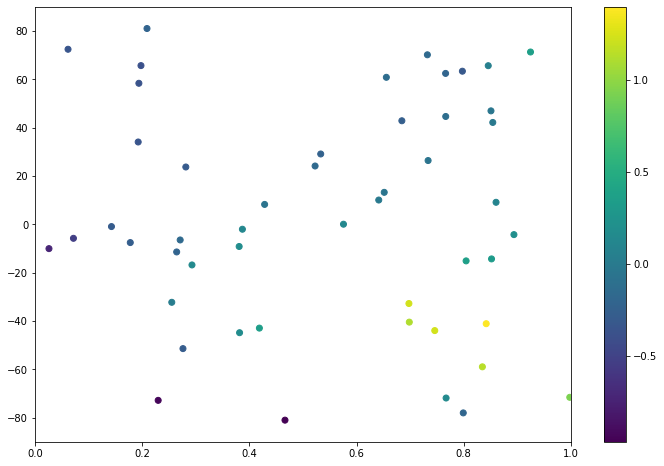

In [32]:
plt.scatter(e_rand, w_rand, c=zscores[:,0])
plt.xlim(0.0, 1.0)
plt.ylim(-90., 90.)
plt.colorbar()